<a href="https://colab.research.google.com/github/thaitaitran/hello-world/blob/master/Thai_Tai_Copy_of_simulating_droplet_fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simulation of droplet fusion

The aim is to simulate the coalescence process of two viscoelastic droplets of different size *r1* and *r2*.

#### References

1. Dahiya, P., Caggioni, M. & Spicer, P. T. Arrested coalescence of viscoelastic droplets: polydisperse doublets. Philosophical Transactions of the Royal Society A 374, 20150132 (2016).

2. Yadha, V. & Helble, J. J. Modeling the coalescence of heterogenous amorphous particles. Journal of Aerosol Science 35, 665–681 (2004).

In [0]:
# get tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

from IPython.display import Image
from IPython.core.display import HTML 

### Define droplet fusion with semianalytical function

Following the articles by Dahiya *et al.* and Yahda *et al.* we define the following 
functions:

In [0]:
r1 = 5
r2 = 9
N = max(r1, r2) / min(r1, r2)

In [0]:
# b = degree of coalescence (1 = no coalescence, 0 = completeness)
def k(b):
    
    head = (N - 1) / (N + 1)
    body = (2 - b**(1/N))**N
    
    rslt = head * body
    return rslt

def c(b):
    
    head = 3*b/(1 + N**3)
    seg1 = np.sqrt(b) * (5/3 - b)
    seg2 = (k(b)**2 / np.sqrt(b)) * (1 + b)

    seg3_partA = (((b - k(b)**2)*(1 - b)**2)/(4*b)) # (((1 - b)**2)*(b - k(b)**2)/(4*b))
    seg3_partB = np.log((1 + b + 2*np.sqrt(b))/(1 + b - 2*np.sqrt(b)))
    
    seg3 = seg3_partA * seg3_partB
    
    body = seg1 + seg2 + seg3
    
    rslt = (head * body)**(-2/3) #Yadha
    #rslt = head * (body**(-2/3)) #Dahiya

    return rslt

# r = outline of two droplets at different stages of coalescence b
def r(θ, b):
    head = np.sqrt(4 * b * c(b))
    body = np.sqrt(1 - b * np.sin(θ)**2)
    tail = k(b) * np.cos(θ)
    
    rslt = head * (body + tail) #Yadha
    #rslt = (head * body) + tail #Dahiya
    return rslt


In [377]:
b = np.linspace(0.9, 0.6, num=10)
θ = np.linspace(-np.pi, np.pi, num = 800)
print(f"k: {k(b)}")
print(f"c: {c(b)}")

k: [0.31561567 0.32621271 0.33715179 0.34845155 0.3601325  0.37221734
 0.38473132 0.39770259 0.41116277 0.42514757]
c: [1.93099884 1.92466381 1.92141986 1.92179772 1.92626444 1.93527228
 1.94929642 1.96886875 1.99461185 2.02727734]


In [0]:
def fusion(b):
    
    rs = r(θ, b)
    xs = rs * np.cos(θ)
    ys = rs * np.sin(θ)
    
    dat = pd.DataFrame({'x': xs, 'y': ys, 'r': rs, 'θ': θ})
    
    return dat


#### Shape at the start of fusion

In [0]:
d1 = fusion(0.999)

In [380]:
d1

,x,y,r,θ
0,-1.998067,-2.446926e-16,1.998067,-3.141593
1,-1.997943,-1.571177e-02,1.998005,-3.133729
2,-1.997573,-3.141966e-02,1.997820,-3.125865
3,-1.996956,-4.711979e-02,1.997512,-3.118001
4,-1.996092,-6.280827e-02,1.997080,-3.110137
...,...,...,...,...
795,-1.996092,6.280827e-02,1.997080,3.110137
796,-1.996956,4.711979e-02,1.997512,3.118001
797,-1.997573,3.141966e-02,1.997820,3.125865
798,-1.997943,1.571177e-02,1.998005,3.133729


In [381]:
d1.max()['r']

3.5987320458404595

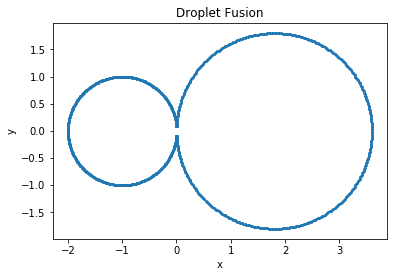

In [382]:
fig, ax = plt.subplots()
ax.scatter(x=d1['x'], y=d1['y'], s=4)

ax.set(xlabel='x', 
       ylabel='y',
       title='Droplet Fusion')
ax.set_aspect('equal')

plt.show()

#### Shape during fusion

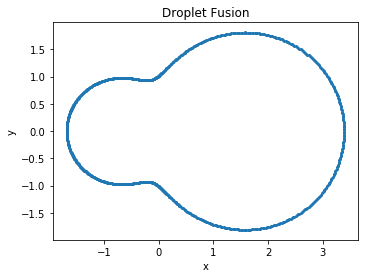

In [383]:
d1 = fusion(0.84)

fig, ax = plt.subplots()
ax.scatter(x=d1['x'], y=d1['y'], s=4)

ax.set(xlabel='x', 
       ylabel='y',
       title='Droplet Fusion')
ax.set_aspect('equal')

plt.show()

##### Shape near end of fusion

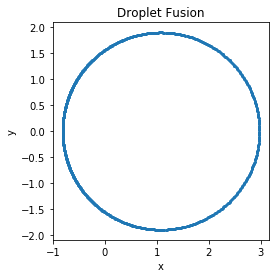

In [384]:
d1 = fusion(0.32)

fig, ax = plt.subplots()
ax.scatter(x=d1['x'], y=d1['y'], s=4)

ax.set(xlabel='x', 
       ylabel='y',
       title='Droplet Fusion')
ax.set_aspect('equal')

plt.show()

## Optimization problem to find **b_min**

Problem is that the shape becomes unrealistic at some point. Droplets curve inwards. Need to find minimum b value that makes sense. The shape is then well defined only in the interval b = [0.999999999, b_min)

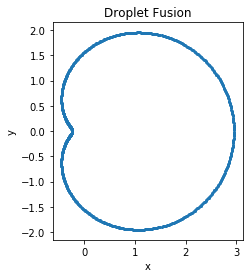

In [385]:
d1 = fusion(0.04)

fig, ax = plt.subplots()
ax.scatter(x=d1['x'], y=d1['y'], s=4)

ax.set(xlabel='x', 
       ylabel='y',
       title='Droplet Fusion')
ax.set_aspect('equal')

plt.show()

In [0]:
# define objective function for optimization procedure

# How to define an objective function? 

# x is b
# y is np.abs(np.abs(d1.max()['x']) + np.abs(d1.min()['x'])) - (np.abs(d1.max()['y']) + np.abs(d1.min()['y']))

def drop_objective(x):
    
    drop = fusion(x)
    
    axial_x = np.abs(drop.max()['x']) + np.abs(drop.min()['x'])
    axial_y = np.abs(drop.max()['y']) + np.abs(drop.min()['y'])
    
    diff = axial_x - axial_y
    
    return diff

In [387]:
# example for b = 0.000001
drop_objective(0.000001)

-0.5242408784696564

In [0]:
# find minimum for object function (should be close to 0.8)
# fmin only works if for all x: drop_objective(x) ≥ 0, e.g. use np.abs(axial_x - axial_y)
import scipy.optimize as opt
#from scipy.optimize import minimize
#x_ = opt.fmin(drop_objective, [0.8])
#print("solved: x={}".format(x_))

In [0]:
# brentq takes less time than fmin
root = opt.brentq(drop_objective, 1e-12, 1 - 1e-8)
# 0.99999999

In [390]:
b_min = root
print(root)

0.3234311361710984


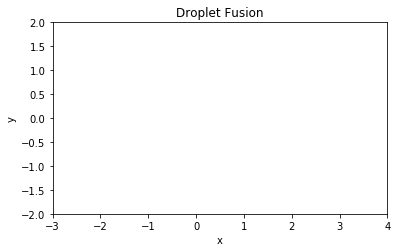

In [391]:
from celluloid import Camera
from IPython.display import HTML

fig, ax = plt.subplots()
camera = Camera(fig)

fusion_df = pd.DataFrame()

for b in np.linspace(0.9999, b_min, num=100):
  droplet = fusion(b)
  droplet['b'] = b
  fusion_df = fusion_df.append(droplet)
  ax.scatter(x=droplet['x'], y=droplet['y'], s=3, c="darkblue")
  plt.xlim(-3, 4)
  plt.ylim(-2, 2)
    
  ax.set(xlabel='x', 
        ylabel='y',
        title='Droplet Fusion')
  ax.set_aspect('equal')
  camera.snap()

animation = camera.animate()
HTML(animation.to_html5_video())

In [0]:
start = fusion_df.query('b == 0.999900')
end = fusion_df.query('b == 0.4949019520254756') #????????

In [0]:
# define utilities to characterise droplets
def combined_area(r1, r2):
    return 4 * np.pi * (r1**2 + r2**2)

def combined_volume(r1, r2):
    return 4 * np.pi/3 * (r1**3 + r2**3)

def volume(r):
    return 4 * np.pi/3 * (r**3)

def area(r):
    return 4 * np.pi * (r**2)

In [394]:
print(f"Droplet radii r1: \t {r1:.2f}")
print(f"Droplet radii r2: \t {r2:.2f}")
print(f"Ratio droplets r1/r2: \t {r1/r2:.2f}")
print()
print(f"Combined area: \t\t {combined_area(r1, r2):.2f}")
print(f"Combined volume: \t {combined_volume(r1, r2):.2f}")
print()
print(f"Area drop 1: \t\t {area(r1):.2f}")
print(f"Area drop 2: \t\t {area(r2):.2f}")
print(f"Ratio area drop 1/2: \t {area(r1)/area(r2):.2f}")
print()
print(f"Volume drop 1: \t\t {volume(r1):.2f}")
print(f"Volume drop 2: \t\t {volume(r2):.2f}")
print(f"Ratio volume drop 1/2: \t {volume(r1)/volume(r2):.2f}")

Droplet radii r1: 	 5.00
Droplet radii r2: 	 9.00
Ratio droplets r1/r2: 	 0.56

Combined area: 		 1332.04
Combined volume: 	 3577.23

Area drop 1: 		 314.16
Area drop 2: 		 1017.88
Ratio area drop 1/2: 	 0.31

Volume drop 1: 		 523.60
Volume drop 2: 		 3053.63
Ratio volume drop 1/2: 	 0.17


In [0]:
# TODO: check ratio of r1 and r2 in results by taking the positive and negative values 